In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jupyter_black

jupyter_black.load()

In [3]:
import numpy as np

from acoustics.plot import plot

from shared import materials, porous_absorber

In [4]:
f = np.arange(15, 20000, 1)

# Flow Resistivity and Thickness

There's a limit to how thick porous absorbent can be effective that is driven by flow resisitivy. The more resisitive a material is the shallower the sound will ultimately penetrate so adding thickness beyond that point would provide no additional benefit. 

Note that it takes a full 2.7m to reach the max of 1000σ.

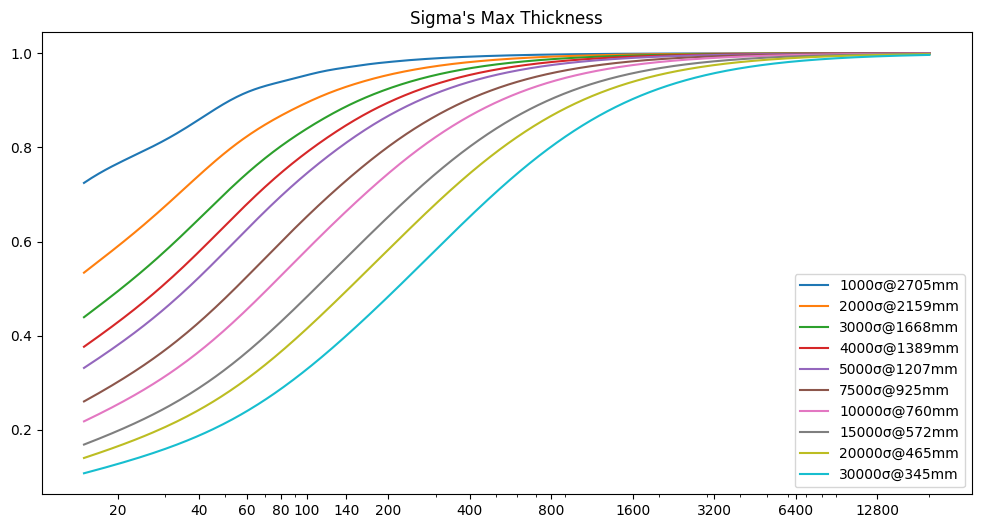

In [5]:
data = {}
for sigma in (1000, 2000, 3000, 4000, 5000, 7500, 10000, 15000, 20000, 30000):
    max_thickness = 3000
    maxx = porous_absorber(
        f, sigma=sigma, thickness=(max_thickness / 1000.0), air_gap=0
    )
    prev = maxx
    for thickness in range(max_thickness - 1, 0, -1):
        a = porous_absorber(f, sigma=sigma, thickness=(thickness / 1000.0), air_gap=0)
        if np.linalg.norm(maxx - a) > 0.05:
            # we've found the point where taking off thickness makes a "difference"
            data[f"{sigma}σ@{thickness + 1}mm"] = prev
            break
        prev = a
ax = plot(f, data, title=f"Sigma's Max Thickness", loc="lower right")

# Maximum Absorption for a Givent Thickness

The corollary is that for a given available treatment thickness there is an optimal flow resisitivy that can be use to get the maximum total absoption. 

Note that this maximum absorption shouldn't be confused with optimum performance in a real-world application with a furnished room and other treatments. It is possible that a specific cruve in combination with optimized choices in other locations will best suit. For example it might be preferable to trade off total absorption for improved absorption in lower frequencies. See fitter notebook for more on this.

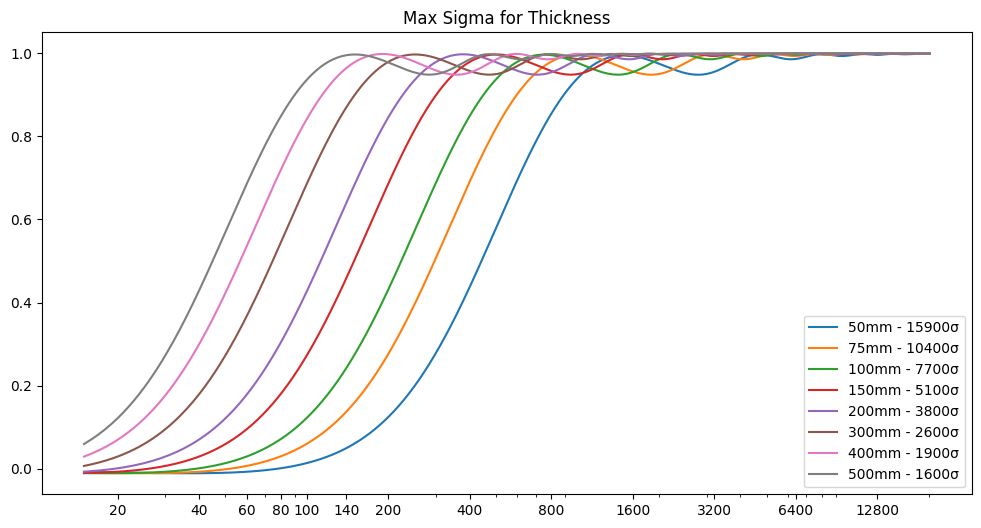

In [6]:
data = {}
for thickness in (50, 75, 100, 150, 200, 300, 400, 500):
    t = thickness / 1000.0
    prev = porous_absorber(f, sigma=1000, thickness=t, air_gap=0)
    for sigma in range(1001, 1000001, 100):
        a = porous_absorber(f, sigma=sigma, thickness=t, air_gap=0)
        if sum(a) < sum(prev):
            # we've found the point where adding sigma made things worse
            data[f"{thickness}mm - {sigma-1}σ"] = prev
            break
        prev = a

ax = plot(f, data, title=f"Max Sigma for Thickness", loc="lower right")

# Multiple Layers of Real World Materials

Unfortunately we cannot order a specific thickness of a specified flow resistivity material and must choose from the options we have available. We can stack multiple layers when space allows though and the following graphs illustrate the results. 

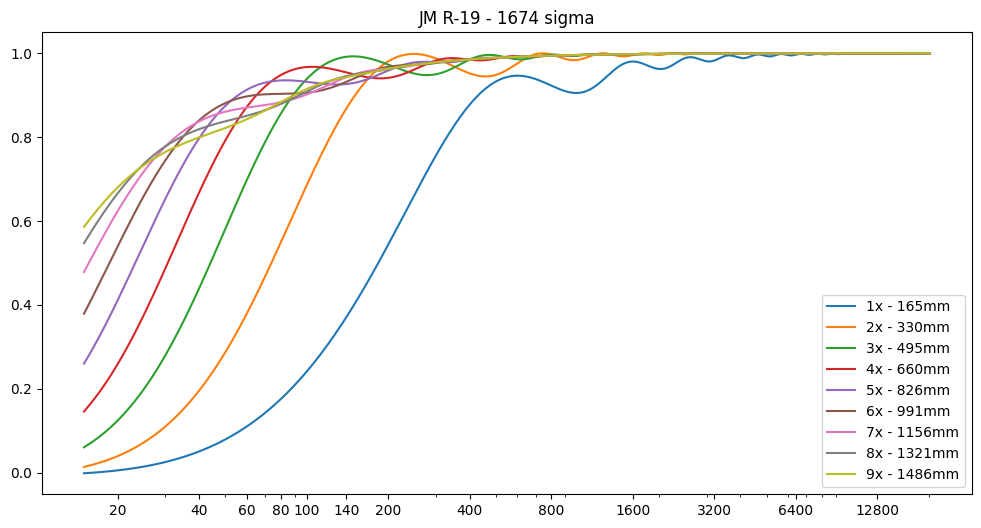

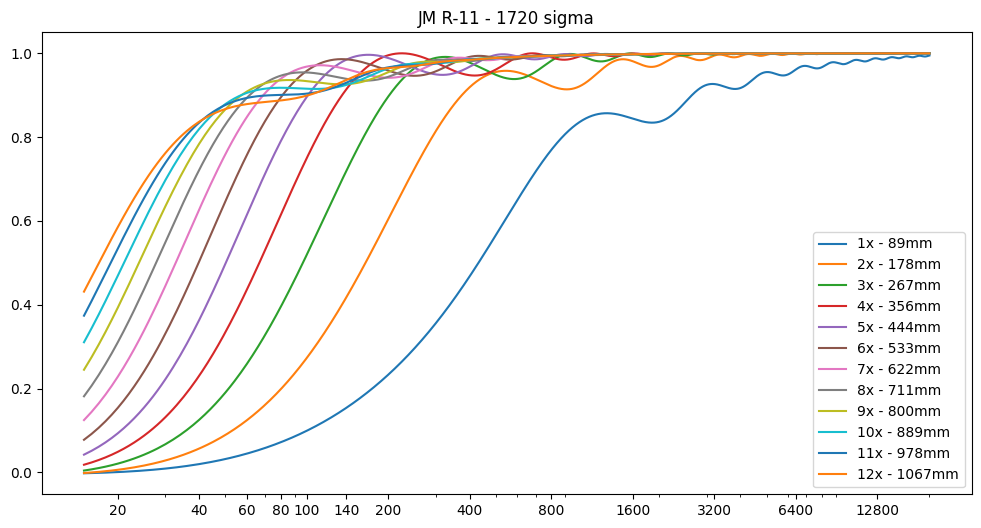

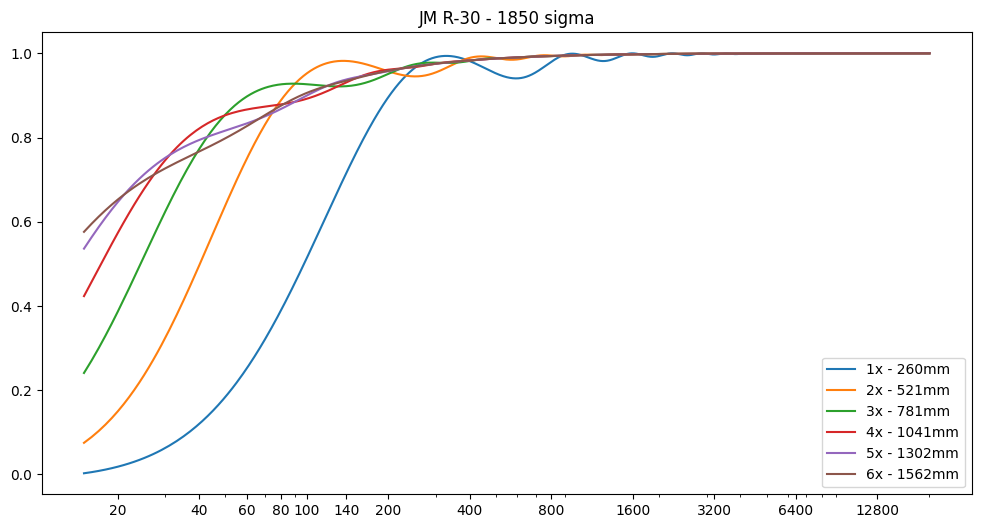

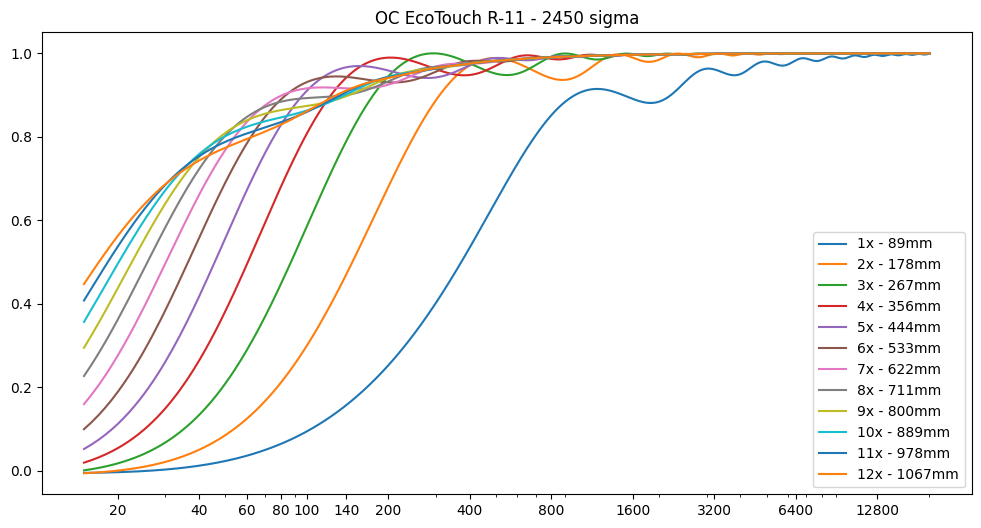

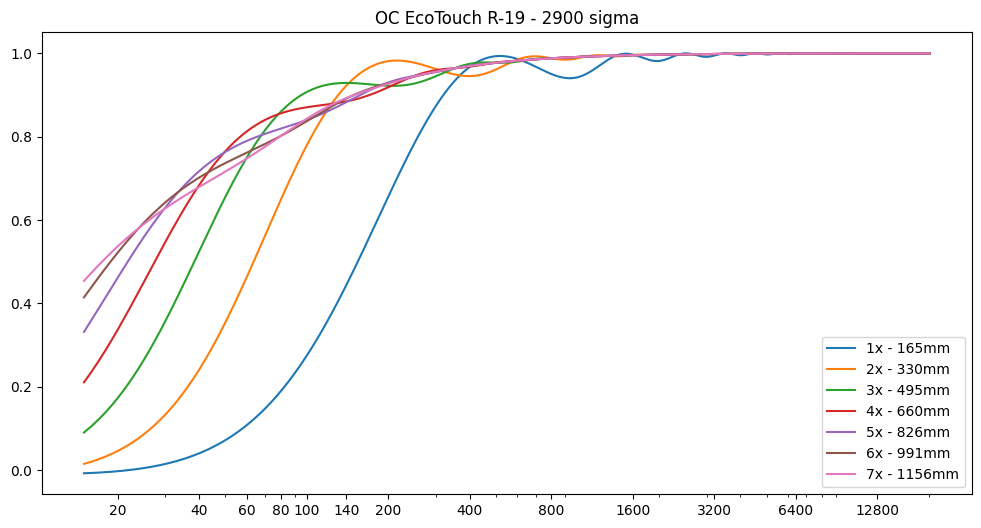

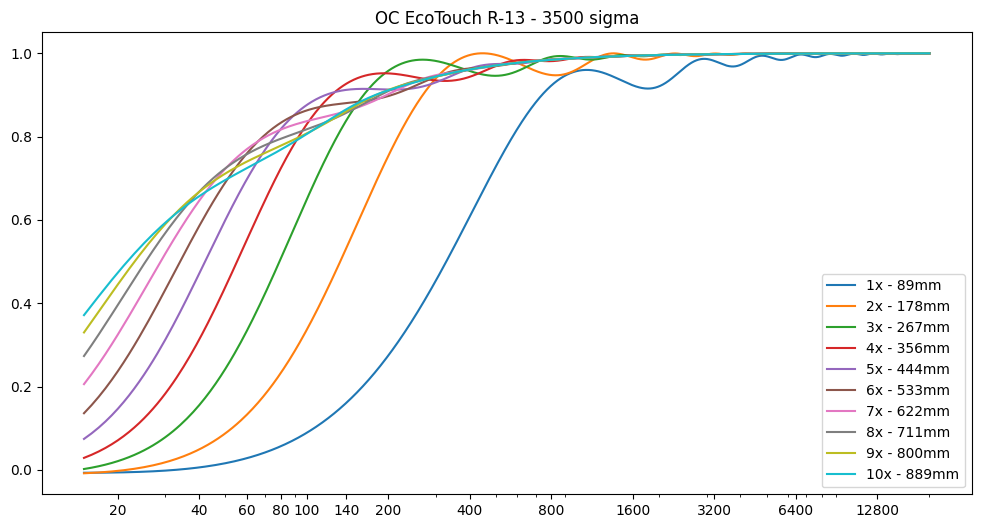

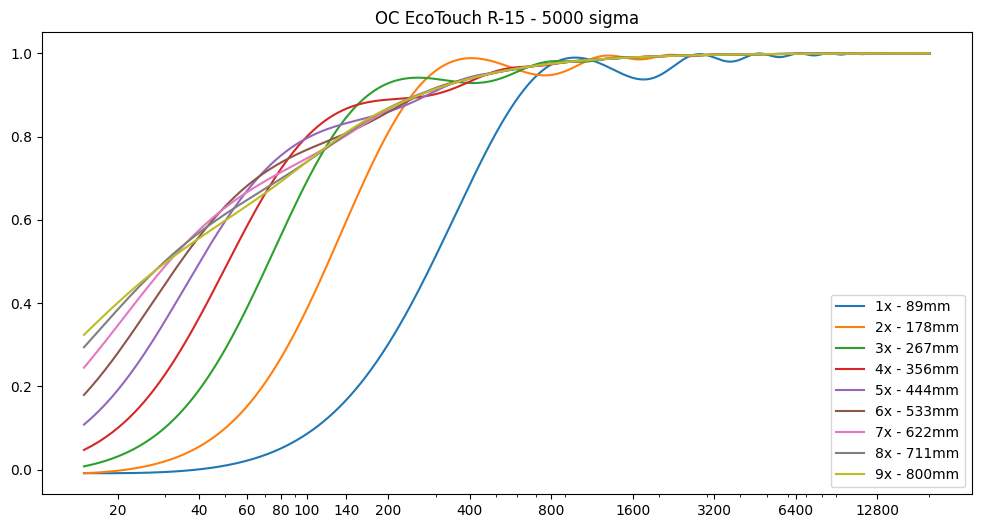

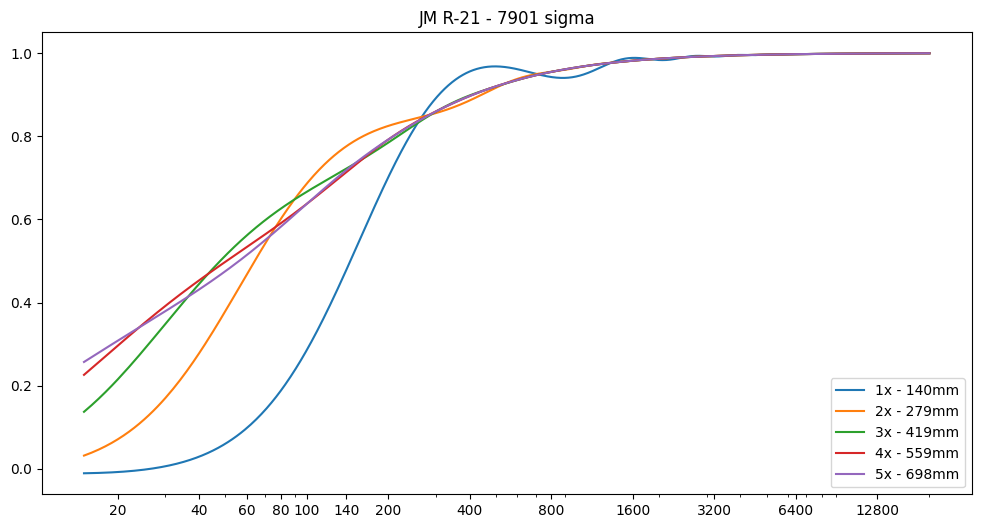

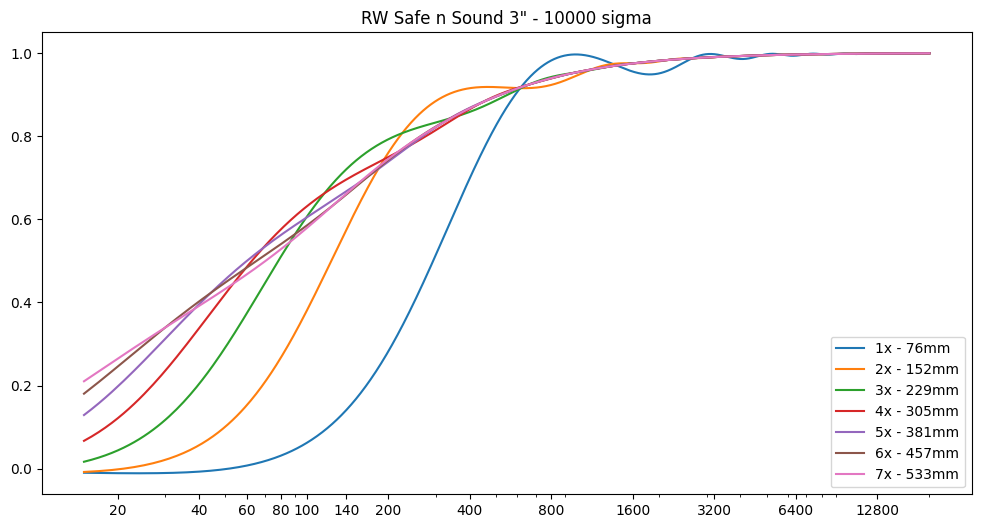

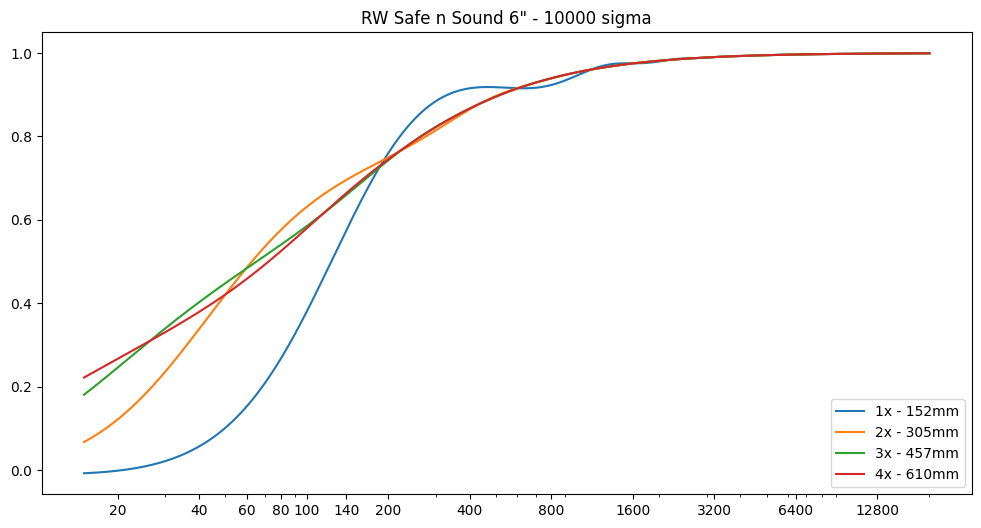

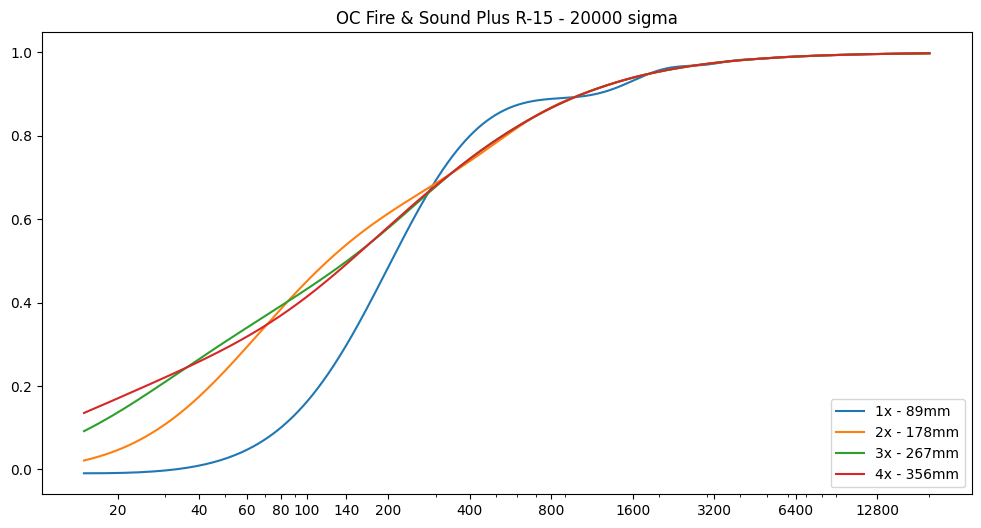

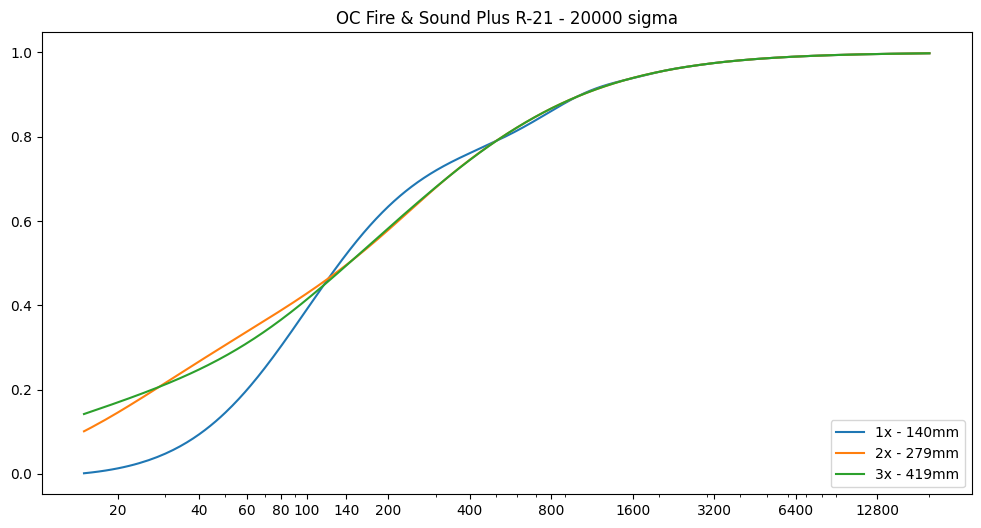

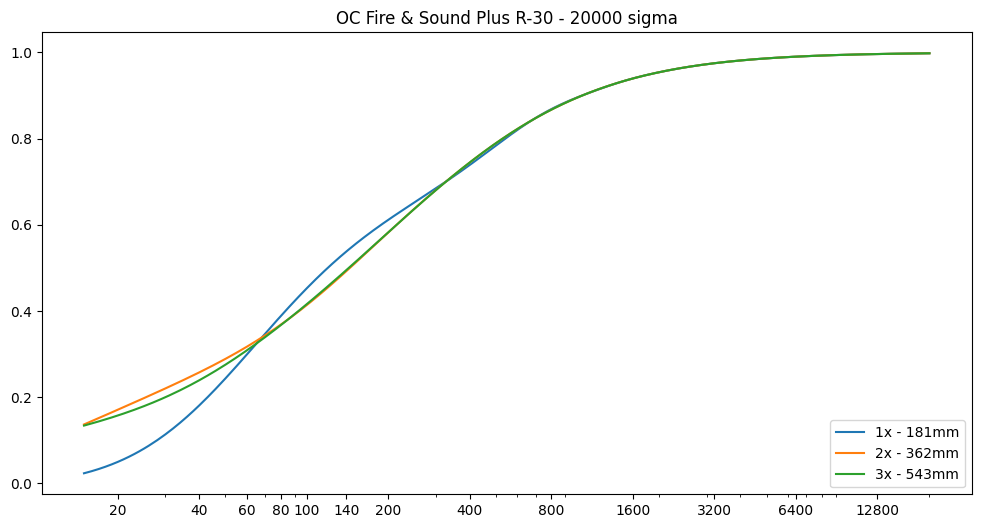

In [7]:
for name, info in sorted(materials.items(), key=lambda d: d[1]["sigma"]):
    data = {}
    sigma = info["sigma"]
    layers = 1
    prev_a = None
    while True:
        thickness = info["thickness"] * layers
        a = porous_absorber(f, sigma=sigma, thickness=thickness, air_gap=0)
        if layers > 12 or (prev_a is not None and np.linalg.norm(a - prev_a) < 0.1):
            break
        data[f"{layers}x - {thickness*1000.0:.0f}mm"] = a
        prev_a = a
        layers += 1
    plot(f, data, title=f"{name} - {sigma} sigma", loc="lower right")